In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random


%matplotlib inline 

from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [137]:
plt.style.use('seaborn')

In [2]:
current_time = datetime.now()
# file_name = current_time.strftime("%Y-%m-%d") + '.csv'
file_name = "2020-09-24.csv"
data_dir = '../input/darksky/daily'
today_weather_sheet = pd.read_csv(data_dir + '/' + file_name)
today_weather_sheet.head(10)

,district,formal_name,lat,long,time,summary,icon,sunriseTime,sunsetTime,moonPhase,...,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,Achham,Asara Ghat,28.950294,81.444319,2020-09-24 00:00:00,Rain until afternoon.,rain,2020-09-24 06:10:00,2020-09-24 18:15:00,0.27,...,14.913,254.8,18.73,2020-09-24 07:03:00,24.55,2020-09-24 15:15:00,20.26,2020-09-24 06:54:00,25.48,2020-09-24 15:23:00
1,Achham,Basti,29.030983,81.171133,2020-09-24 00:00:00,Rain until afternoon.,rain,2020-09-24 06:11:00,2020-09-24 18:16:00,0.27,...,15.172,255.7,19.93,2020-09-24 07:35:00,26.31,2020-09-24 15:04:00,21.57,2020-09-24 07:04:00,28.49,2020-09-24 15:02:00
2,Achham,Mangalsen,29.136114,81.250092,2020-09-24 00:00:00,Rain in the morning and afternoon.,rain,2020-09-24 06:11:00,2020-09-24 18:16:00,0.27,...,15.865,255.4,17.02,2020-09-24 08:25:00,21.59,2020-09-24 14:57:00,18.61,2020-09-24 06:54:00,22.90,2020-09-24 15:03:00
3,Achham,Sugali,29.179807,81.372939,2020-09-24 00:00:00,Rain in the morning and afternoon.,rain,2020-09-24 06:10:00,2020-09-24 18:15:00,0.27,...,15.457,254.1,15.09,2020-09-24 06:59:00,19.97,2020-09-24 14:53:00,17.01,2020-09-24 06:18:00,21.81,2020-09-24 14:55:00
4,Arghakhanchi,Rangsing,27.803303,82.784008,2020-09-24 00:00:00,Heavy rain and humid throughout the day.,rain,2020-09-24 06:05:00,2020-09-24 18:09:00,0.27,...,6.449,252.9,20.49,2020-09-24 07:55:00,23.09,2020-09-24 13:28:00,21.85,2020-09-25 00:00:00,24.33,2020-09-24 13:23:00
5,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-24 00:00:00,Rain throughout the day.,rain,2020-09-24 06:03:00,2020-09-24 18:08:00,0.27,...,8.050,251.1,16.81,2020-09-24 06:57:00,19.98,2020-09-24 12:51:00,17.79,2020-09-25 00:00:00,21.21,2020-09-24 12:53:00
6,Arghakhanchi,Sidhara,27.794500,82.828383,2020-09-24 00:00:00,Heavy rain and humid throughout the day.,rain,2020-09-24 06:05:00,2020-09-24 18:09:00,0.27,...,6.110,252.9,20.26,2020-09-24 08:23:00,22.88,2020-09-24 13:14:00,21.29,2020-09-25 00:00:00,24.07,2020-09-24 13:15:00
7,Baglung,Baglung,28.263636,83.600322,2020-09-24 00:00:00,Rain throughout the day.,rain,2020-09-24 06:01:00,2020-09-24 18:06:00,0.27,...,7.350,249.2,15.22,2020-09-24 06:48:00,18.35,2020-09-24 13:19:00,16.45,2020-09-24 06:45:00,19.43,2020-09-24 13:11:00
8,Baglung,Dhorpatan,28.483333,83.083333,2020-09-24 00:00:00,Rain in the morning and afternoon.,rain,2020-09-24 06:04:00,2020-09-24 18:08:00,0.27,...,8.133,246.5,9.14,2020-09-24 03:35:00,10.37,2020-09-24 00:00:00,8.66,2020-09-24 09:04:00,13.13,2020-09-24 20:00:00
9,Baglung,Galkot,28.218692,83.418811,2020-09-24 00:00:00,Rain throughout the day.,rain,2020-09-24 06:02:00,2020-09-24 18:07:00,0.27,...,7.427,249.4,13.55,2020-09-24 06:47:00,17.00,2020-09-24 11:57:00,14.81,2020-09-24 06:35:00,17.96,2020-09-24 12:01:00


In [56]:
class WeatherExtractor:
    def __init__(self, data_dir= "../input/darksky/daily"):
        self.data_dir = data_dir

    def fetch_place_weather(self, district: str, location: str) -> dict:
        """
        Get weather attributes of given district->places: temperature, humidity, rainfall

        @param district:
        @param location:
        @return:
        """

        weather_list = []
        weather_data = pd.DataFrame([], columns=[])
        for daily_weather_log in os.listdir(self.data_dir):
            daily_weather = pd.read_csv(self.data_dir + '/' + daily_weather_log)
            location_weather = daily_weather[
                (daily_weather['district'] == district) & (daily_weather['formal_name'] == location)]
            # location_weather = location_weather.drop(['district', 'formal_name'], axis=1)
            # weather_list.append(location_weather)

            weather_data = weather_data.append(location_weather)
            # print(weather_list)
        # weather_data = pd.concat(weather_list)
        # weather_data = weather_list.drop(['Unnamed: 0'], axis=1)

        # weather_data = weather_data.drop(['Unnamed: 0'], axis=1)

        # select only required fields from today weather
        required_fields = ['district', 'formal_name', 'temperatureMin', 'temperatureMax', 'precipIntensity',
                           'precipIntensityMax', 'humidity', 'dewPoint', 'pressure', 'windSpeed', 'windGust',
                          ]
        
        weather_data.index = pd.to_datetime(weather_data["time"])
#         weather_data = weather_data[required_fields]
        weather_data = weather_data

        weather_attr = weather_data
#         weather_attr.index = daily_weather_log
        
        return weather_attr

#         weather_result = {"temperature": weather_attr['temperatureMax'],
#                           "humidity": weather_attr['humidity'] * 100,
#                           "rainfall": random.uniform(40., 250.)}

#         print("Weather Data: ", weather_result)
#         return weather_result

In [57]:
weather_extract = WeatherExtractor()

In [58]:
user_request = {'district': 'Arghakhanchi', 'location': 'Sandhikharka'}
w_result = weather_extract.fetch_place_weather(user_request['district'], user_request['location'])

In [65]:
w_result.sort_index().head()

,district,formal_name,lat,long,time,summary,icon,sunriseTime,sunsetTime,moonPhase,...,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipAccumulation
time,,,,,,,,,,,,,,,,,,,,,
2020-09-06,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-06 00:00:00,Humid and partly cloudy throughout the day.,rain,2020-09-06 05:55:00,2020-09-06 18:29:00,0.64,...,262.9,18.01,2020-09-06 05:20:00,28.38,2020-09-06 13:08:00,18.82,2020-09-06 05:17:00,31.74,2020-09-06 13:29:00,NaN
2020-09-07,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-07 00:00:00,Humid and partly cloudy throughout the day.,rain,2020-09-07 05:56:00,2020-09-07 18:28:00,0.67,...,263.9,18.79,2020-09-07 04:39:00,28.21,2020-09-07 12:44:00,19.65,2020-09-07 04:39:00,30.99,2020-09-07 12:55:00,NaN
2020-09-08,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-08 00:00:00,Humid and overcast throughout the day.,cloudy,2020-09-08 05:56:00,2020-09-08 18:27:00,0.70,...,267.5,18.98,2020-09-08 06:23:00,27.04,2020-09-08 12:44:00,19.74,2020-09-08 06:23:00,28.85,2020-09-08 12:50:00,NaN
2020-09-09,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-09 00:00:00,Humid and partly cloudy throughout the day.,rain,2020-09-09 05:57:00,2020-09-09 18:26:00,0.73,...,265.1,18.49,2020-09-09 05:27:00,28.96,2020-09-09 12:49:00,19.15,2020-09-09 05:26:00,31.77,2020-09-09 13:08:00,NaN
2020-09-10,Arghakhanchi,Sandhikharka,27.964022,83.120569,2020-09-10 00:00:00,Humid and mostly cloudy throughout the day.,rain,2020-09-10 05:57:00,2020-09-10 18:25:00,0.76,...,259.9,18.73,2020-09-10 05:37:00,27.44,2020-09-10 12:01:00,19.44,2020-09-10 05:38:00,29.20,2020-09-10 12:12:00,NaN


In [64]:
w_result.columns

Index(['district', 'formal_name', 'lat', 'long', 'time', 'summary', 'icon',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensity',
       'precipIntensityMax', 'precipIntensityMaxTime', 'precipProbability',
       'precipType', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'humidity', 'pressure',
       'windSpeed', 'windGust', 'windGustTime', 'windBearing', 'cloudCover',
       'uvIndex', 'uvIndexTime', 'visibility', 'ozone', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'precipAccumulation'],
      dtype='object')

In [114]:
required_fields = ['precipIntensity', 'precipIntensityMax', 'humidity', 'dewPoint', 'pressure', 
                   'windSpeed', 'windGust', 'temperatureMin', 'temperatureMax', 
                          ]
w_result = w_result[required_fields].sort_index()

# ARIMA Model 
[MachineLearningMastry](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

## EDA

In [115]:
w_result.describe()

,precipIntensity,precipIntensityMax,humidity,dewPoint,pressure,windSpeed,windGust,temperatureMin,temperatureMax
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.205582,0.513052,0.730455,15.866818,1008.034091,1.304091,2.518864,17.263864,27.973409
std,0.519370,0.879506,0.188087,6.029833,2.618534,0.344014,1.505106,2.458679,2.872795
min,0.000000,0.000000,0.170000,-4.160000,1003.400000,0.980000,1.580000,6.510000,19.040000
25%,0.010475,0.055800,0.665000,15.475000,1006.275000,1.105000,1.907500,16.790000,27.492500
50%,0.054550,0.258600,0.745000,17.775000,1007.700000,1.225000,2.060000,17.795000,28.420000
75%,0.225350,0.673075,0.872500,19.802500,1009.600000,1.347500,2.252500,18.550000,29.500000
max,3.371600,5.466100,1.000000,21.620000,1016.700000,2.520000,8.110000,19.760000,33.890000


In [116]:
# Data Cleaning

def show_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    if missing_data.empty:
        print("No any null Values")
        return
#     missing_data.plot.bar(subplots=True, figsize=(16,9))
    sns.pairplot(missing_data)

show_missing_data(w_result)

No any null Values


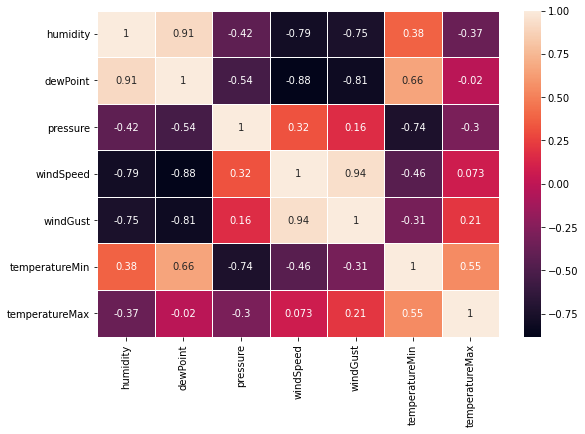

In [117]:
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(w_result.iloc[:, 2:].corr(), annot=True,linewidths=.5, ax=ax);

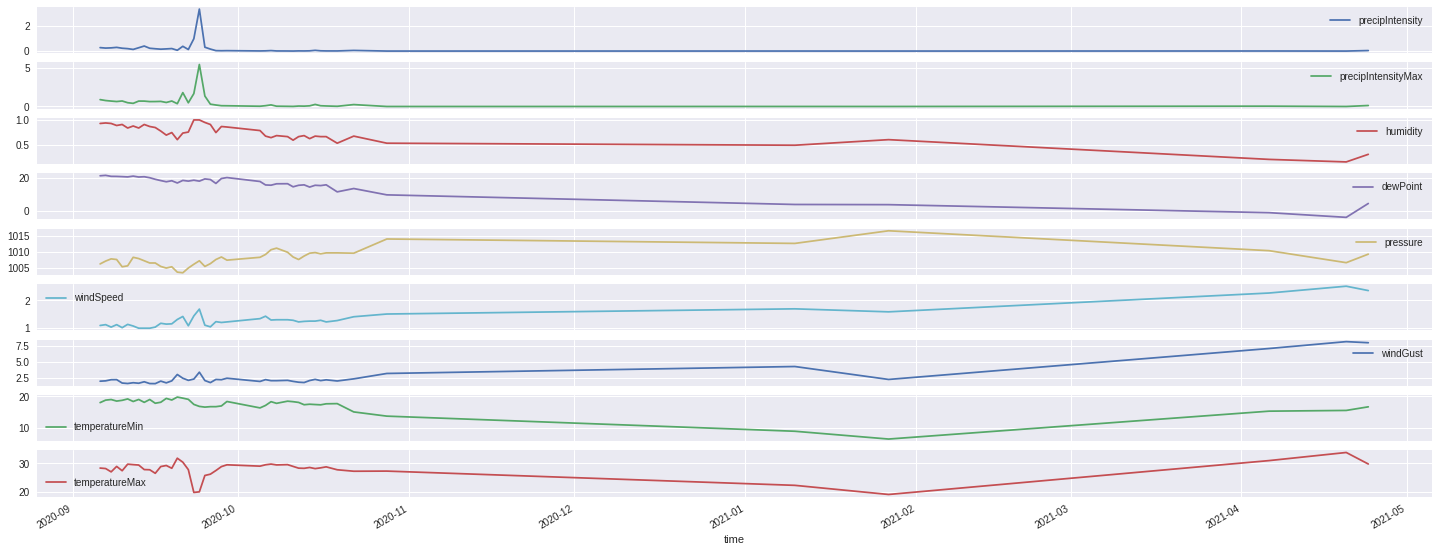

In [139]:
w_result.plot(subplots=True, figsize=(25, 10));

In [121]:
train_data = w_result[:30]
test_data = w_result[30:]

In [134]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(15,9))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [135]:
# Augmented Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

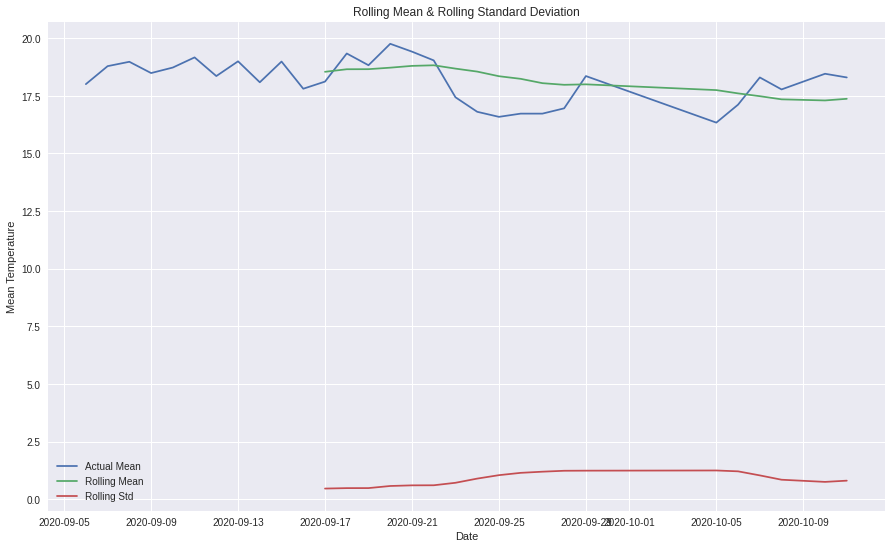

Test statistic:  -2.5483884414778797
Critical Values: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}


In [138]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_data.temperatureMin)
perform_dickey_fuller_test(train_data.temperatureMin)

/home/codemonk/development_tools/pyenv/mlenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

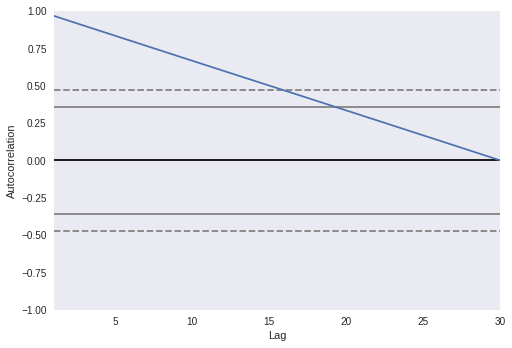

In [156]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(train_data)
plt.show();

In [165]:
model = ARIMA(train_data.values.reshape(-1).tolist(), order=(16, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [161]:
train_data.values.reshape(-1).tolist()

[0.2768,
 0.8956,
 0.93,
 21.36,
 1006.2,
 1.08,
 1.96,
 18.01,
 28.38,
 0.2395,
 0.7754,
 0.94,
 21.62,
 1007.1,
 1.11,
 2.01,
 18.79,
 28.21,
 0.2568,
 0.7057,
 0.93,
 21.01,
 1007.8,
 1.02,
 2.19,
 18.98,
 27.04,
 0.2964,
 0.6457,
 0.89,
 20.97,
 1007.6,
 1.11,
 2.2,
 18.49,
 28.96,
 0.2279,
 0.7171,
 0.91,
 20.83,
 1005.3,
 1.0,
 1.67,
 18.73,
 27.44,
 0.1945,
 0.4916,
 0.84,
 20.66,
 1005.6,
 1.12,
 1.6,
 19.17,
 29.76,
 0.1315,
 0.4099,
 0.88,
 21.15,
 1008.3,
 1.06,
 1.72,
 18.36,
 29.59,
 0.2669,
 0.7046,
 0.84,
 20.6,
 1007.9,
 0.98,
 1.64,
 19.0,
 29.45,
 0.4038,
 0.7015,
 0.91,
 20.77,
 1007.2,
 0.98,
 1.87,
 18.09,
 27.85,
 0.2245,
 0.6378,
 0.87,
 20.17,
 1006.5,
 0.98,
 1.59,
 18.99,
 27.78,
 0.1857,
 0.6433,
 0.85,
 19.2,
 1006.5,
 1.02,
 1.58,
 17.81,
 26.53,
 0.1517,
 0.6636,
 0.78,
 18.41,
 1005.4,
 1.16,
 1.97,
 18.12,
 28.91,
 0.1737,
 0.523,
 0.7,
 17.69,
 1004.9,
 1.13,
 1.7,
 19.34,
 29.29,
 0.2009,
 0.7123,
 0.75,
 18.31,
 1005.3,
 1.14,
 2.01,
 18.83,
 28.31,
 